# ***📘 LinkedIn Job Trend Analysis***

# ***🎯 Phase 1: Data Cleaning and Preprocessing***

# ***Import Libraries***

In [ ]:
import pandas as pd

# ***Load Dataset***

In [3]:
from google.colab import files
uploaded = files.upload()

Saving linkedin_job_posts_insights.xlsx to linkedin_job_posts_insights.xlsx


In [4]:
df = pd.read_excel("linkedin_job_posts_insights.xlsx")

# ***Basic Dataset Info***

In [5]:
print("Initial Shape:", df.shape)
print("Column Names:", df.columns.tolist())
print("Missing Values:\n", df.isnull().sum())

Initial Shape: (31597, 9)
Column Names: ['job_title', 'company_name', 'location', 'hiring_status', 'date', 'seniority_level', 'job_function', 'employment_type', 'industry']
Missing Values:
 job_title            26
company_name        940
location              9
hiring_status         0
date                  0
seniority_level    1308
job_function       1590
employment_type    1591
industry           2011
dtype: int64


# ***Clean Text Columns***

In [6]:
text_columns = df.select_dtypes(include='object').columns
df[text_columns] = df[text_columns].apply(lambda x: x.str.strip().str.replace(r'\n+', ' ', regex=True))


# ***Drop Duplicates and Nulls***

In [7]:
df.drop_duplicates(inplace=True)
df.dropna(subset=['job_title', 'location'], inplace=True)

# ***Split Location into City / State / Country***

In [8]:
location_split = df['location'].str.split(',', expand=True)
df['city'] = location_split[0].str.strip()
df['state'] = location_split[1].str.strip() if location_split.shape[1] > 1 else None
df['country'] = location_split[2].str.strip() if location_split.shape[1] > 2 else None

# ***Final Preview***

In [9]:
df[['job_title', 'company_name', 'city', 'state', 'country']].head()

,job_title,company_name,city,state,country
0,Store Business Manager - DAVID JONES CHERMSIDE,M.J. Bale,Brisbane,Queensland,Australia
1,Full-time,Gatesman,Chicago,IL,None
2,Senior Machine Learning Engineer,Redwolf + Rosch,Adelaide,South Australia,Australia
3,Senior Data Scientist,Bupa,Melbourne,Victoria,Australia
4,Solution Architect,Xybion Digital,Chennai,Tamil Nadu,India


# ***Cleaned Dataset***

In [10]:
df.to_excel('cleaned_linkedin_jobs.xlsx', index=False)

# ***🔥 Phase 2: Skill Trends by City – Heatmap***

# ***Visualization Libraries***

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

# ***Skill Extraction Logic***

In [12]:
# ✅ Define a basic skill keyword list (expand as needed)
skill_keywords = [
    'python', 'sql', 'excel', 'tableau', 'power bi', 'machine learning',
    'data analysis', 'data science', 'deep learning', 'statistics',
    'communication', 'cloud', 'aws', 'azure', 'pandas', 'numpy'
]

# ✅ Function to match skills in job title
def extract_skills(text):
    if pd.isnull(text):
        return []
    text = text.lower()
    return [skill for skill in skill_keywords if skill in text]

# ✅ Apply skill extraction
df['skills_found'] = df['job_title'].apply(extract_skills)


# ***Skill List for Counting***

In [13]:
# ✅ Explode the 'skills_found' list so each row has one skill
df_exploded = df.explode('skills_found')
df_exploded = df_exploded.dropna(subset=['skills_found', 'city'])

# ✅ Count top 10 skills per city
skill_counts = df_exploded.groupby(['city', 'skills_found']).size().reset_index(name='count')
top_skills = skill_counts.groupby('skills_found')['count'].sum().sort_values(ascending=False).head(10).index
filtered_skills = skill_counts[skill_counts['skills_found'].isin(top_skills)]


# ***Pivot Table and Heatmap***

<ipython-input-16-d68aace194f7>:12: UserWarning: Glyph 128293 (\N{FIRE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128293 (\N{FIRE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


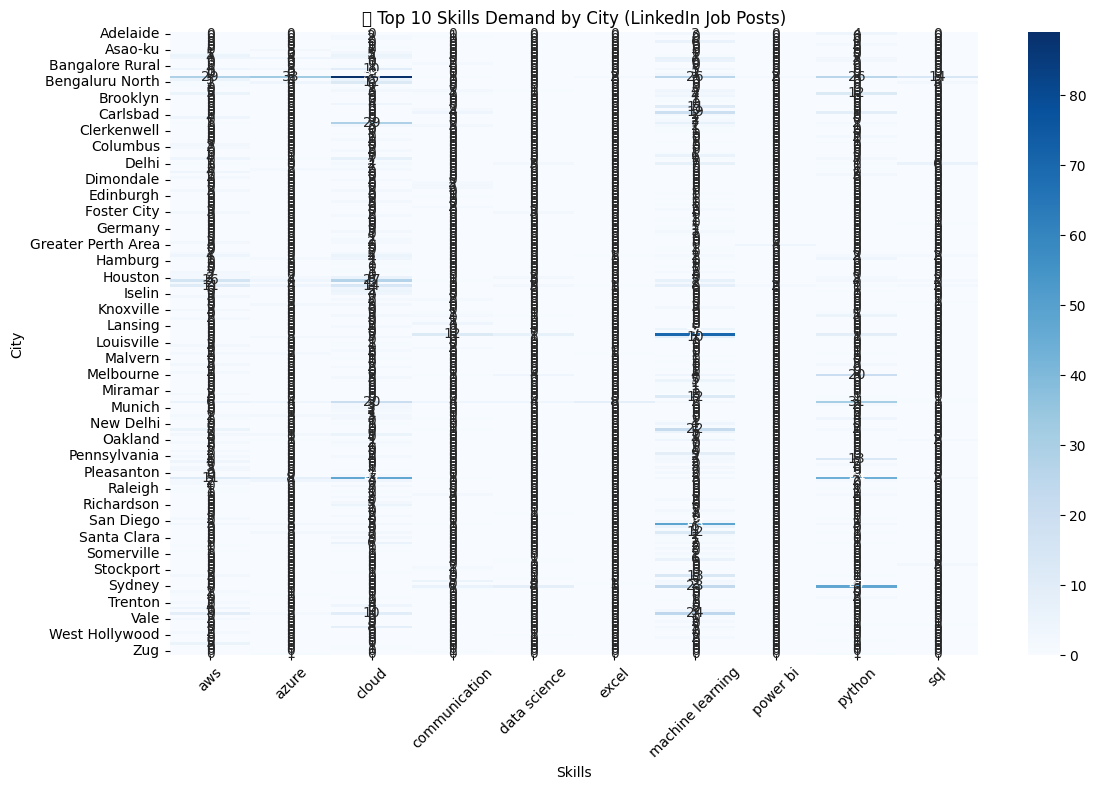

In [16]:
# ✅ Create pivot table
pivot_table = filtered_skills.pivot(index='city', columns='skills_found', values='count').fillna(0)

# ✅ Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(pivot_table, annot=True, fmt=".0f", cmap='Blues')
plt.title('🔥 Top 10 Skills Demand by City (LinkedIn Job Posts)')
plt.xlabel('Skills')
plt.ylabel('City')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


# ***🧠 Phase 3: Skill vs Role Matrix***

# ***Role Extraction Logic***

In [17]:
# ✅ Define common job roles (can be expanded)
role_keywords = [
    'data analyst', 'data scientist', 'machine learning engineer',
    'business analyst', 'data engineer', 'ai engineer',
    'research scientist', 'statistician'
]

# ✅ Function to map roles from job_title
def extract_role(text):
    if pd.isnull(text):
        return None
    text = text.lower()
    for role in role_keywords:
        if role in text:
            return role
    return 'other'  # fallback if no role matches

# ✅ Apply to DataFrame
df['job_role'] = df['job_title'].apply(extract_role)


# ***Skill vs Role Matrix***

In [18]:
# Merge roles into the exploded DataFrame
df_exploded['job_role'] = df_exploded['job_title'].apply(extract_role)

# ✅ Create Skill vs Role matrix
role_skill_matrix = df_exploded.groupby(['job_role', 'skills_found']).size().unstack(fill_value=0)

# ***Visualize Matrix as Heatmap***

<ipython-input-19-13d973e27504>:9: UserWarning: Glyph 129504 (\N{BRAIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129504 (\N{BRAIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


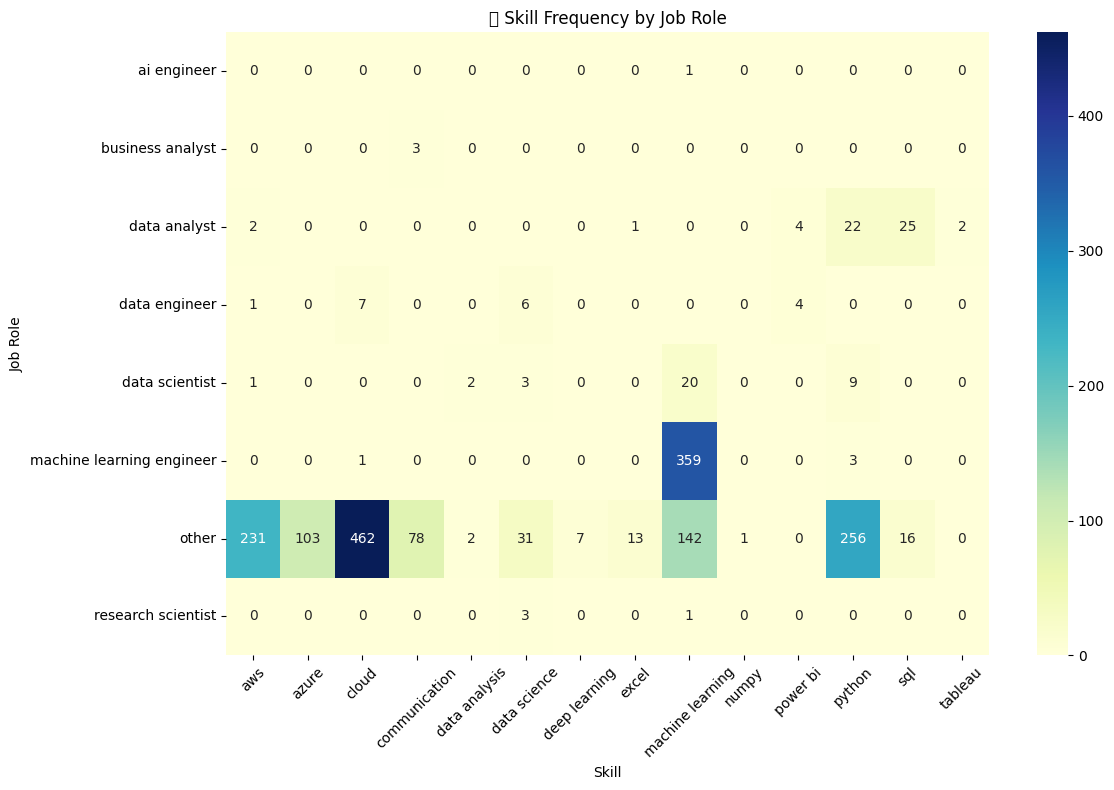

In [19]:
# ✅ Plot heatmap of skill frequency by role
plt.figure(figsize=(12, 8))
sns.heatmap(role_skill_matrix, annot=True, fmt="d", cmap="YlGnBu")
plt.title("🧠 Skill Frequency by Job Role")
plt.xlabel("Skill")
plt.ylabel("Job Role")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


# ***🚀 Phase 4: Job Demand Recommendation System***

# ***Skill-Based Demand Recommendation***

In [20]:
# ✅ Group by skill and city to recommend high-demand locations

def recommend_cities_for_skill(skill_input):
    skill_input = skill_input.lower()
    filtered = df_exploded[df_exploded['skills_found'] == skill_input]
    top_cities = filtered['city'].value_counts().head(5)
    return top_cities

# ✅ Group by skill and job role to recommend suitable roles

def recommend_roles_for_skill(skill_input):
    skill_input = skill_input.lower()
    filtered = df_exploded[df_exploded['skills_found'] == skill_input]
    top_roles = filtered['job_role'].value_counts().head(5)
    return top_roles


# ***Try Recommendation Example***

In [21]:
# ✅ Try with any skill like 'python', 'sql', 'excel', etc.
skill_to_check = 'python'

print(f"📍 Top cities for skill '{skill_to_check}':\n")
print(recommend_cities_for_skill(skill_to_check))

print("\n🧑‍💼 Top job roles for skill '{skill_to_check}':\n")
print(recommend_roles_for_skill(skill_to_check))


📍 Top cities for skill 'python':

city
Sydney       47
Pune         44
Mumbai       31
Bengaluru    26
Melbourne    20
Name: count, dtype: int64

🧑‍💼 Top job roles for skill '{skill_to_check}':

job_role
other                        256
data analyst                  22
data scientist                 9
machine learning engineer      3
Name: count, dtype: int64
